# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows, and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [24]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_google_genai langchain_community langgraph_sdk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
from dotenv import load_dotenv, dotenv_values

# Load environment variables from .env.example
load_dotenv("../.env.example")

def debug_api_key(key_name):
    print(f"\nDebugging {key_name}:")
    
    # Check environment variable
    env_value = os.getenv(key_name)
    print(f"1. Value from os.getenv('{key_name}'): {env_value}")
    
    # Check .env.example file directly
    config = dotenv_values("../.env.example")
    dotenv_value = config.get(key_name)
    print(f"2. Value from .env.example: {dotenv_value}")
    
    # Read .env.example file manually
    try:
        with open("../.env.example", 'r') as f:
            content = f.read()
            print(f"3. Content of .env.example:")
            print(content)
    except FileNotFoundError:
        print("3. Error: .env.example file not found")
    
    # Try to parse the value manually
    if dotenv_value:
        cleaned_value = dotenv_value.strip().strip("'").strip('"')
        print(f"4. Cleaned value: {cleaned_value}")
        
        # Set the environment variable
        os.environ[key_name] = cleaned_value
        print(f"5. Environment variable set. New value: {os.getenv(key_name)}")
    else:
        print("4. Unable to parse value from .env.example")

# Debug both API keys
debug_api_key('TAVILY_API_KEY')
debug_api_key('GOOGLE_API_KEY')
debug_api_key('LANGCHAIN_API_KEY')

print("\nFinal environment variable values:")
print(f"TAVILY_API_KEY:{os.getenv('TAVILY_API_KEY')}")
print(f"GOOGLE_API_KEY: {os.getenv('GOOGLE_API_KEY')}")
print(f"LANGCHAIN_API_KEY: {os.getenv('LANGCHAIN_API_KEY')}")

In [7]:
os.environ["GOOGLE_API_KEY"] = os.environ.get('GOOGLE_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "langraphlearningMODULE4 (1)"






# Understanding Python's Special Methods: `__init__` and `__call__`

## 1. `__init__`: The Constructor

### Purpose
- Special method in Python called the constructor
- Automatically invoked when creating an object from a class
- Main purpose: Initialize the object's initial state

### Example Code
```python
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
```

### How It Works
When you create an object:
```python
node_a = ReturnNodeValue("I'm A")
```

#### Parameters
- `node_secret`: The value passed during object creation
- `self`: Reference to the current instance of the class

#### Inside `__init__`
```python
self._value = node_secret
```
- Creates new attribute `_value` on the object
- Underscore (_) suggests internal use within class
- Stores passed value (e.g., "I'm A") in `self._value`

#### End Result
```python
node_a._value  # Contains "I'm A"
```

### Analogy
Think of `__init__` like unpacking a new device - it's the setup process, putting in batteries, and getting it ready to work.

## 2. `__call__`: Making Objects Callable

### Purpose
- Makes an object callable like a function
- Allows calling the object itself, not just its methods

### Example Code
```python
def __call__(self, state: State) -> Any:
    print(f"Adding {self._value} to {state['state']}")
    return {"state": [self._value]}
```

### How It Works
Usage example:
```python
node_a({"state": "initial"})
```

#### Inside `__call__`
- `self`: References object instance
- `state`: Argument passed when object is called
- Prints status message
- Returns modified state dictionary

#### Output Example
```
Adding I'm A to initial
```

#### Return Value
```python
{"state": ["I'm A"]}
```

### Complete Example
```python
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret  # Store the value when object is created

    def __call__(self, state: dict):
        # Runs when object is called like a function
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}  # Modify and return state

# Create and use object
node_a = ReturnNodeValue("I'm A")
new_state = node_a({"state": "initial"})
# Prints: Adding I'm A to initial
# Returns: {"state": ["I'm A"]}
```

## Key Differences

1. **`__init__`**
   - Runs once during object creation
   - Sets up initial state
   - Called automatically when instantiating

2. **`__call__`**
   - Runs each time object is called as function
   - Performs operation with stored state
   - Called manually by using object like function

### Analogy
If `__init__` is setting up a device, `__call__` is like pressing its button to perform its function.

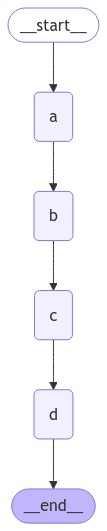

In [27]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        print(f"Passing Value {self._value}")
        print(f"State Value {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [9]:
graph.invoke({"state": []})

Adding I'm A to []
Passing Value I'm A
State Value []
Adding I'm B to ["I'm A"]
Passing Value I'm B
State Value ["I'm A"]
Adding I'm C to ["I'm B"]
Passing Value I'm C
State Value ["I'm B"]
Adding I'm D to ["I'm C"]
Passing Value I'm D
State Value ["I'm C"]


{'state': ["I'm D"]}

Now, let's run `b` and `c` in parallel.

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

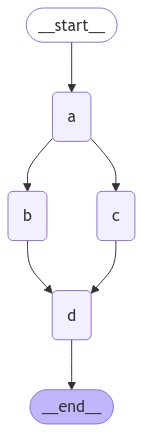

In [10]:
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**!

This is because both `b` and `c` are writing to the same state key / channel in the same step.

In [11]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Passing Value I'm A
State Value []
Adding I'm B to ["I'm A"]
Passing Value I'm B
State Value ["I'm A"]
Adding I'm C to ["I'm A"]
Passing Value I'm C
State Value ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

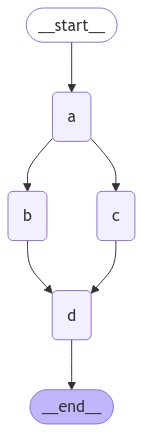

In [12]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"state": []})

Adding I'm A to []
Passing Value I'm A
State Value []
Adding I'm B to ["I'm A"]
Passing Value I'm B
State Value ["I'm A"]
Adding I'm C to ["I'm A"]
Passing Value I'm C
State Value ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Passing Value I'm D
State Value ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

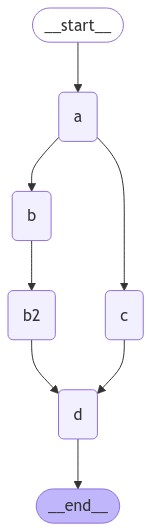

In [14]:
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`.

In [15]:
graph.invoke({"state": []})

Adding I'm A to []
Passing Value I'm A
State Value []
Adding I'm B to ["I'm A"]
Passing Value I'm B
State Value ["I'm A"]
Adding I'm C to ["I'm A"]
Passing Value I'm C
State Value ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Passing Value I'm B2
State Value ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]
Passing Value I'm D
State Value ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**.

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

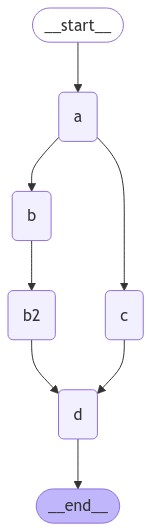

In [20]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
graph.invoke({"state": []})

Adding I'm A to []
Passing Value I'm A
State Value []
Adding I'm B to ["I'm A"]
Passing Value I'm B
State Value ["I'm A"]
Adding I'm C to ["I'm A"]
Passing Value I'm C
State Value ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Passing Value I'm B2
State Value ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]
Passing Value I'm D
State Value ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

Now, the reducer sorts the updated state values!

## Working with LLMs

Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")


c:\Users\devvs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [30]:
# import os, getpass

# %env TAVILY_API_KEY = {userdata.get('TAVILY_API_KEY')}

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")
# _set_env("TAVILY_API_KEY")

env: TAVILY_API_KEY={userdata.get('TAVILY_API_KEY')}


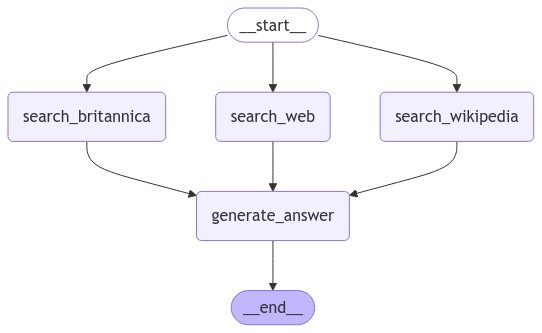

In [122]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
from bs4 import BeautifulSoup
from typing import List, Dict
import time
from urllib.parse import quote

def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=1).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_britannica(state: Dict) -> Dict:
    """
    Retrieve documents from Britannica based on a search query with improved error handling
    """
    
    def get_britannica_results(query: str, max_results: int = 1) -> List[Dict]:
        # Format the query for URL
        encoded_query = quote(query)
        search_url = f"https://www.britannica.com/search?query={encoded_query}"
        
        try:
            # Add more complete headers to better mimic a browser
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                'Connection': 'keep-alive',
            }
            
            # Get search results page
            response = requests.get(search_url, headers=headers)
            response.raise_for_status()
            
            # Print status code and URL for debugging
            print(f"Search URL: {search_url}")
            print(f"Status Code: {response.status_code}")
            
            # Parse the search results
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Try different possible selectors for search results
            search_results = (
                soup.find('div', class_='search-results') or  # Try original selector
                soup.find('div', class_='search-content') or  # Alternative class
                soup.find('div', {'data-testid': 'search-results'}) or  # Possible data attribute
                soup.find('ul', class_='list-unstyled') # Another common pattern
            )
            
            if not search_results:
                print("No search results container found. HTML structure:")
                print(soup.prettify()[:1000])  # Print first 1000 chars of HTML for debugging
                return []
            
            # Find all article links
            article_links = search_results.find_all('a', href=True)
            
            if not article_links:
                print("No article links found in search results")
                return []
                
            documents = []
            
            # Process each article link
            for link in article_links[:max_results]:
                # Only process links that point to articles
                if not link['href'].startswith('/'):
                    continue
                    
                article_url = f"https://www.britannica.com{link['href']}"
                print(f"Fetching article: {article_url}")
                
                # Get the article content
                article_response = requests.get(article_url, headers=headers)
                article_response.raise_for_status()
                
                article_soup = BeautifulSoup(article_response.text, 'html.parser')
                
                # Try different possible content selectors
                content_div = (
                    article_soup.find('div', class_='article-content') or
                    article_soup.find('article') or
                    article_soup.find('div', {'data-testid': 'article-content'})
                )
                
                if content_div:
                    # Get all paragraphs
                    paragraphs = content_div.find_all('p')
                    if paragraphs:
                        content = ' '.join([p.get_text().strip() for p in paragraphs])
                        
                        # Get title with fallbacks
                        title = (
                            article_soup.find('h1', class_='document-title') or
                            article_soup.find('h1') or
                            article_soup.find('title')
                        )
                        title_text = title.get_text().strip() if title else "Untitled"
                        
                        documents.append({
                            "url": article_url,
                            "title": title_text,
                            "content": content[:2000]  # Limit content length
                        })
                        print(f"Successfully extracted content from: {article_url}")
                    else:
                        print(f"No paragraphs found in article: {article_url}")
                else:
                    print(f"No content div found in article: {article_url}")
                    
                # # Add delay between requests
                # time.sleep(1)
            
            return documents
            
        except requests.RequestException as e:
            print(f"Request error: {str(e)}")
            return []
        except Exception as e:
            print(f"Unexpected error: {str(e)}")
            return []
    
    # Get the search results
    search_docs = get_britannica_results(state['question'])
    
    if not search_docs:
        print("No documents were retrieved from Britannica")
        return {"context": []}
    
    # Format the results
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="Britannica" href="{doc["url"]}" title="{doc["title"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """You must answer the following question using the following context.\nQUESTION: {question} \nCONTEXT: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder: StateGraph = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("search_britannica", search_britannica)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_britannica")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_britannica", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [143]:
from pprint import pprint
result = graph.invoke({"question": "what are AI Agents?"})
pprint(result['answer'].content)

Search URL: https://www.britannica.com/search?query=what%20are%20AI%20Agents%3F
Status Code: 200
Fetching article: https://www.britannica.com/topic/list-of-sculptors-2019702
Successfully extracted content from: https://www.britannica.com/topic/list-of-sculptors-2019702
('An AI agent is a software program that can **interact with its '
 'environment**, **collect data**, and **use that data to perform tasks** in '
 'order to achieve predetermined goals. These goals are set by humans, but the '
 'AI agent independently chooses the best actions to take to achieve them. \n'
 '\n'
 'Here are some key characteristics of AI agents:\n'
 '\n'
 '* **Autonomy:** They can operate independently, making decisions and taking '
 'actions without direct human intervention.\n'
 '* **Goal-oriented:** They are designed to achieve specific objectives, '
 "whether it's completing a task, optimizing a process, or providing "
 'information.\n'
 '* **Learning and Adaptation:** Many AI agents can learn from thei

## Using with LangGraph API

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

*Also, if you are running this notebook in CoLab, then skip this step.*

--

Let's load our the above graph in the Studio UI, which uses `module-4/studio/parallelization.py` set in `module-4/studio/langgraph.json`.

![Screenshot 2024-08-29 at 3.05.13 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb10f43c3d4df239e0278_parallelization-1.png)

Let's get the URL for the local deployment from Studio.

In [ ]:
import platform

if 'google.colab' in str(get_ipython()) or platform.system() != 'Darwin':
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:63082")

In [ ]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="parallelization",
                                      input=input_question,
                                      stream_mode="values"):
    # Check if answer has been added to state
    answer = event.data.get('answer', None)
    if answer:
        print(answer['content'])

Nvidia's Q2 2024 earnings were exceptionally strong. The company reported $13.5 billion in revenue, significantly surpassing expectations, and made $6 billion in pure profit. The earnings per share were $2.70, adjusted, compared to the $2.09 per share expected by analysts. The gross profit margins were 75.1%, and the adjusted earnings per share were 68 cents. The strong performance was driven by unprecedented demand for its generative AI chips.
